In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from patsy import dmatrix
import aesara.tensor as at

from py12box_invert.paths import Paths
from py12box_invert.invert import Invert
from py12box_invert.plot import plot_mf, plot_emissions
from py12box import core

Use a set of knots and splines to estimate emissions over time.
Just do a standard Normal inversion with MCMC

In [2]:
species = "CFC-11"
project_path = Paths.data / f"example/{species}"

In [ ]:
# Just run to get matrices
inv_true = Invert(project_path, species, method="analytical_gaussian", n_threads=4, sensitivity_freq="yearly", start_year=2000, end_year=2020)
inv_true.run_inversion([70., 20., 10., 10.])

In [ ]:
# Get all years where we have data
# Note, there's no data in 2020 so the times in the H matrix are only until 2019
time = np.arange(2000,2021)

In [ ]:
# Start by just having 11 evenly spaced knots over the 20 years
knot_list = np.linspace(2000,2020, 10)

B_i = dmatrix(
    "bs(time, knots=knots, degree=3, include_intercept=False) - 1",
    {"time": time, "knots": knot_list[1:-1]},
)

# As we have 4 boxes, we're going to have to repeat it
B = np.repeat(np.asarray(B_i, order="F"), 4, axis=0)

In [ ]:
# Now do the MCMC
# For now just put a prior on each knot of N(0, 100^2). 
# Actually set the prior on a standard normal, then scale
# Better would be to extract each knot's prior at the right time
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    w_ = pm.Normal("w_", mu=0, sigma=1, size=B.shape[1], dims="splines")
    w = pm.Deterministic("w",  0 + 100*w_)
    x = pm.Deterministic("mu", inv_true.mat.H @ B @ w.T)
    Y = pm.Normal("Y", mu=x, sigma=np.diag(inv_true.mat.R), observed=inv_true.mat.y, dims="obs")

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=50000, tune=10000, chains=2, step=pm.Metropolis()))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
# Get posterior mean of knots
wp = idata.posterior["w"].mean(("chain", "draw")).values
x_hat = np.dot(B,wp.T)

In [ ]:
# Lazy way to plot results 
apriori = inv_true.mod.emissions[::12].sum(1)
plt.plot(time, apriori + np.sum(inv_true.mat.x_hat.reshape(-1,4),1))
plt.plot(time, apriori + np.sum(x_hat.reshape(-1,4),1))


# Matt's version

Useful websites:

https://bayesiancomputationbook.com/markdown/chp_05.html
https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html


In [29]:
inv_mcmc_zero = Invert(project_path, species, method="mcmc_lat_gradient", n_threads=4, sensitivity_freq="monthly", start_year=2000, end_year=2020,
                sensitivity_from_zero=True)


Setting up inversion for CFC-11

No units given for emissions. Assuming Gg/yr
No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 3 iterations
... stratospheric lifetime: 55.0
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 55.0
... done in 0.0001 s
Calculating flux sensitivity on 4 threads...


/Users/chxmr/code/py12box_invert/py12box_invert/invert.py:117: UserWarning: Can't have both a start_year and ic_years
 Setting ic_years to None.
  warnings.warn("Can't have both a start_year and ic_years\n Setting ic_years to None.")


... done
Setting initial conditions to constant value
... done


In [30]:
inv_mcmc_zero.create_matrices([10, 10, 10, 10], from_zero=True)

In [31]:
def logistic(L, k, x0, x):
    return L/(1. + np.exp(-k*(x - x0)))

In [6]:
#TODO: hard-wiring annual global emissions at the moment. Need to fix.
#nyears = int(inv_mcmc_zero.mod_prior.emissions.shape[0]/12)
#emissions_global = inv_mcmc_zero.mod_prior.emissions.sum(axis=1)
#emissions_global_annual = emissions_global.reshape((int(emissions_global.shape[0]/12), 12)).mean(axis=1)

In [32]:
# Set up splines
time = inv_mcmc_zero.mod_prior.time.copy()
time

array([2000.        , 2000.08333333, 2000.16666667, 2000.25      ,
       2000.33333333, 2000.41666667, 2000.5       , 2000.58333333,
       2000.66666667, 2000.75      , 2000.83333333, 2000.91666667,
       2001.        , 2001.08333333, 2001.16666667, 2001.25      ,
       2001.33333333, 2001.41666667, 2001.5       , 2001.58333333,
       2001.66666667, 2001.75      , 2001.83333333, 2001.91666667,
       2002.        , 2002.08333333, 2002.16666667, 2002.25      ,
       2002.33333333, 2002.41666667, 2002.5       , 2002.58333333,
       2002.66666667, 2002.75      , 2002.83333333, 2002.91666667,
       2003.        , 2003.08333333, 2003.16666667, 2003.25      ,
       2003.33333333, 2003.41666667, 2003.5       , 2003.58333333,
       2003.66666667, 2003.75      , 2003.83333333, 2003.91666667,
       2004.        , 2004.08333333, 2004.16666667, 2004.25      ,
       2004.33333333, 2004.41666667, 2004.5       , 2004.58333333,
       2004.66666667, 2004.75      , 2004.83333333, 2004.91666

In [48]:
spinup = 10 # years

finite_times = np.isfinite(inv_mcmc_zero.obs.mf)*np.repeat(np.expand_dims(inv_mcmc_zero.mod_prior.time, axis=1), 4, axis=1)
#finite_times = finite_times[finite_times > 0.].flatten()
num_knots = 5

# distribute knots over period after spinup, weighted by data density
knots_list = np.quantile(finite_times[(finite_times > 0.) * (finite_times > inv_mcmc_zero.obs.time[0] + spinup)], np.linspace(0, 1, num_knots))

# prepend start year
knots_list = np.insert(knots_list, 0, inv_mcmc_zero.obs.time[0])

knots_list

array([2000.        , 2010.08333333, 2012.5       , 2014.91666667,
       2017.27083333, 2019.91666667])

In [49]:
B = dmatrix(
    "bs(time, knots=knots, degree=3, include_intercept=True) - 1",
    {"time": time, "knots": knots_list[1:-1]},
)
B_array = np.asarray(B)
B.shape

(240, 8)

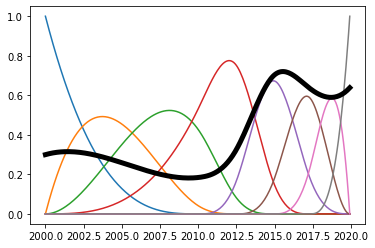

In [50]:
plt.plot(time, B)
w = np.random.rand(B.shape[1])
plt.plot(time, B@w, linewidth=5, color="black")

In [53]:
with pm.Model() as model:

    # Logistic function parameters (L is normalisation so that sum from 0 -> 3 is 1)
    k = pm.Uniform("k", lower=0.1, upper=3.)
    x0 = pm.Uniform("x0", lower=0., upper=10.)
    L = 1/(1/(1+np.exp(-k*(0 - x0))) + \
            1/(1+np.exp(-k*(1 - x0))) + \
            1/(1+np.exp(-k*(2 - x0))) + \
            1/(1+np.exp(-k*(3 - x0))))

    # Get scaling factor for each box (note that these are intentionally ordered 3 -> 0, because box0 is the biggest)
    x_box3 = pm.Deterministic("x_box3", logistic(L, k, x0, 0))
    x_box2 = pm.Deterministic("x_box2", logistic(L, k, x0, 1))
    x_box1 = pm.Deterministic("x_box1", logistic(L, k, x0, 2))
    x_box0 = pm.Deterministic("x_box0", logistic(L, k, x0, 3))

    x_knots = pm.TruncatedNormal("x_splines",
                        mu=1, sigma=1, lower=0, 
                        shape = B.shape[1],
                        )

    x_global = pm.TruncatedNormal("x_global", mu=100., sigma=100., lower=0.)

    x_global_annual = pm.Deterministic("x_annual", x_global * pm.math.dot(B_array, x_knots))

    x_boxes = at.stack([x_box0*x_global_annual,
                        x_box1*x_global_annual,
                        x_box2*x_global_annual,
                        x_box3*x_global_annual], axis=1)

    x_emissions = pm.Deterministic("x_emissions", at.flatten(x_boxes))

    x_ic = pm.Normal("x_ic",
                mu=inv_mcmc_zero.mod_prior.ic[0],
                sigma=inv_mcmc_zero.mod_prior.ic[0]*0.1,
                shape=(1,)) # TODO: currently hard-wired 10% uncertainty

    x = pm.Deterministic("x", at.concatenate([x_ic, x_emissions]))

    y_observed = pm.MvNormal(
        "y",
        mu=inv_mcmc_zero.mat.H @ x,
        cov=inv_mcmc_zero.mat.R,
        observed=inv_mcmc_zero.mat.y,
    )

    #prior = pm.sample_prior_predictive(samples=10, model=model)

    #trace = pm.sample(return_inferencedata=True)
    trace = pm.sample(return_inferencedata=True, step=pm.Metropolis())  #draws=1000, tune=500, 


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [k]
>Metropolis: [x0]
>Metropolis: [x_splines]
>Metropolis: [x_global]
>Metropolis: [x_ic]


/opt/miniconda3/envs/pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/miniconda3/envs/pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/miniconda3/envs/pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/miniconda3/envs/pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.


<ErrorbarContainer object of 3 artists>

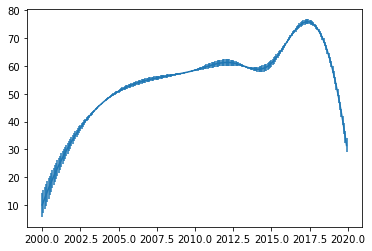

In [58]:
plt.errorbar(time, trace.posterior.sel(chain=0).x_annual.data.mean(axis=0), yerr=trace.posterior.sel(chain=0).x_annual.data.std(axis=0))